## This notebook recreates the figures in the EMBC conference paper which is [here](../EMBS_conference_paper.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
from nilearn import input_data, datasets, plotting, signal
from scipy import stats
import os
import pickle

In [2]:
## Load the precomputed dataframe
path_to_df = '../data/precomputed/df_fc.pkl'
df = pd.read_pickle(path_to_df)

In [3]:
## Inspect the dataframe
df.head()


,fc,roi1,roi2,subject,time_window,condition
0,0.392815,Retrocalcarine cortex RH,Superior longitudinal fasciculus II mid-poster...,0,pre,active
1,0.629210,Retrocalcarine cortex RH,Arcuate fasciculus mid-anterior RH,0,pre,active
2,0.077016,Retrocalcarine cortex RH,Cerebrospinal fluid (between middle frontal gy...,0,pre,active
3,0.317872,Retrocalcarine cortex RH,Precentral sulcus mid-inferior RH,0,pre,active
4,-0.135184,Retrocalcarine cortex RH,Putamen inferior RH,0,pre,active


In [4]:
## TIMING OF EACH EXPERIMENTAL SESSION: PRE, FUS, POST
IDX_PRE= range(60,300) # we start at 60 instead of 0 because of some strange artifact at the beginning of the time series
IDX_FUS = range(300,600)
IDX_POST = range(600,900)

# the 1-based indices of the subgenual region (sgACC: our target region) in the DiFuMo atlas, where 0 is the background
IDX_SUBGENUAL = 133

In [5]:
# load DiFuMo atlas
difumo = datasets.fetch_atlas_difumo(dimension=1024)
df_labels = pd.DataFrame(difumo.labels)  # List of 1024 anatomical labels
atlas_img = nib.load(difumo.maps)
subgenual = df_labels.loc[IDX_SUBGENUAL,'difumo_names']
#df_labels.head()
df_labels.tail()


,component,difumo_names,yeo_networks7,yeo_networks17,gm,wm,csf
1019,1020,Parieto-occipital sulcus anterior RH,VisCent,DefaultC,0.747118,0.157032,0.095855
1020,1021,Cerebellum IX,No network found,No network found,0.578940,0.142701,0.144514
1021,1022,Cuneus postero-inferior LH,VisCent,VisPeri,0.518821,0.169658,0.238200
1022,1023,Caudate superior anterior,No network found,No network found,0.699400,0.054205,0.246384
1023,1024,Corpus callosum genu RH,No network found,No network found,0.211941,0.530518,0.257551


## Figure 2

In [6]:
with open('../data/precomputed/difumo_time_series.pkl', 'rb') as f:
    time_series = pickle.load(f)

bold_3d_active = np.array(time_series['active'])
bold_3d_sham = np.array(time_series['sham'])

print(f"Shape of bold_3d_active: {bold_3d_active.shape} (subjects, time points, ROIs)")
print(f"Shape of bold_3d_sham: {bold_3d_sham.shape} (subjects, time points, ROIs)")

#for s in range(bold_3d_active.shape[0]):

Shape of bold_3d_active: (16, 900, 1024) (subjects, time points, ROIs)
Shape of bold_3d_sham: (16, 900, 1024) (subjects, time points, ROIs)


In [7]:
# compute functional connectivity matrix for each subject and condition
for s in range(bold_3d_active.shape[0]):
    bold_3d_active[s,:,:] = signal.clean(bold_3d_active[s,:,:], detrend=False, standardize=False)
    bold_3d_sham[s,:,:] = signal.clean(bold_3d_sham[s,:,:], detrend=False, standardize=False)
    
    # compute functional connectivity matrix for this subject and condition
    corrmat_active_pre = np.corrcoef(bold_3d_active[s,IDX_PRE,:].T)
    corrmat_active_fus = np.corrcoef(bold_3d_active[s,IDX_FUS,:].T)
    corrmat_active_post = np.corrcoef(bold_3d_active[s,IDX_POST,:].T)
    
    corrmat_sham_pre = np.corrcoef(bold_3d_sham[s,IDX_PRE,:].T)
    corrmat_sham_fus = np.corrcoef(bold_3d_sham[s,IDX_FUS,:].T)
    corrmat_sham_post = np.corrcoef(bold_3d_sham[s,IDX_POST,:].T)
    
    if s == 0:
        all_corrmat_active_pre = corrmat_active_pre
        all_corrmat_active_fus = corrmat_active_fus
        all_corrmat_active_post = corrmat_active_post
        
        all_corrmat_sham_pre = corrmat_sham_pre
        all_corrmat_sham_fus = corrmat_sham_fus
        all_corrmat_sham_post = corrmat_sham_post
        
    else:
        all_corrmat_active_pre = np.dstack((all_corrmat_active_pre, corrmat_active_pre))
        all_corrmat_active_fus = np.dstack((all_corrmat_active_fus, corrmat_active_fus))
        all_corrmat_active_post = np.dstack((all_corrmat_active_post, corrmat_active_post))
        
        all_corrmat_sham_pre = np.dstack((all_corrmat_sham_pre, corrmat_sham_pre))
        all_corrmat_sham_fus = np.dstack((all_corrmat_sham_fus, corrmat_sham_fus))
        all_corrmat_sham_post = np.dstack((all_corrmat_sham_post, corrmat_sham_post))
        

In [8]:
# compute the main dependent variables for both active and sham, averaged across subjects:
## difference in FC between FUS and PRE
## difference in FC between POST and PRE
dels_active = np.mean(all_corrmat_active_fus - all_corrmat_active_pre, axis=2)
dels_sham = np.mean(all_corrmat_sham_fus - all_corrmat_sham_pre, axis=2)
dels_active_post = np.mean(all_corrmat_active_post - all_corrmat_active_pre, axis=2)
dels_sham_post = np.mean(all_corrmat_sham_post - all_corrmat_sham_pre, axis=2)

bsl_active = np.mean(all_corrmat_active_pre, axis=2)
bsl_sham = np.mean(all_corrmat_sham_pre, axis=2)

# create a 1d vector that contains all elements above the main diagonal of dels_active and dels_sham
dels_active = dels_active[np.triu_indices(dels_active.shape[0], k=1)]
dels_sham = dels_sham[np.triu_indices(dels_sham.shape[0], k=1)]
dels_active_post = dels_active_post[np.triu_indices(dels_active_post.shape[0], k=1)]
dels_sham_post = dels_sham_post[np.triu_indices(dels_sham_post.shape[0], k=1)]
bsl_active = bsl_active[np.triu_indices(bsl_active.shape[0], k=1)]
bsl_sham = bsl_sham[np.triu_indices(bsl_sham.shape[0], k=1)]

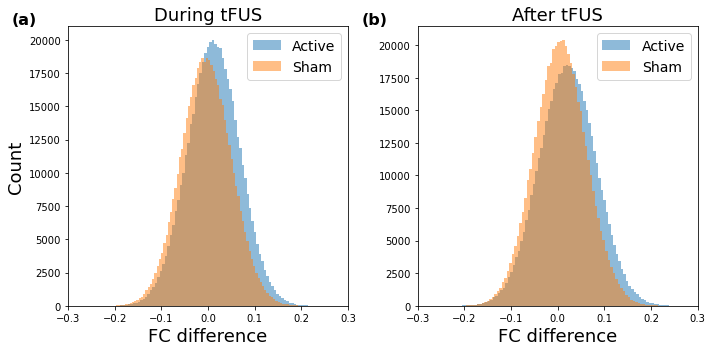

In [9]:
# plot a histogram of the differences
## in this figure, we look at all FCs (global effects), not just the ones involving the sgACC
fontdict = {'fontsize': 18, 'fontweight': 'normal'}

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(dels_active, bins=100, alpha=0.5, label='Active')
ax[0].hist(dels_sham, bins=100, alpha=0.5, label='Sham')
ax[0].legend(fontsize=14)

ax[1].hist(dels_active_post.flatten(), bins=100, alpha=0.5, label='Active')
ax[1].hist(dels_sham_post.flatten(), bins=100, alpha=0.5, label='Sham')
ax[1].legend(fontsize=14)

ax[0].set_xlim(-0.3, 0.3)
ax[1].set_xlim(-0.3, 0.3)

ax[0].set_xlabel('FC difference', fontdict=fontdict)
ax[1].set_xlabel('FC difference', fontdict=fontdict)

ax[0].set_ylabel('Count', fontdict=fontdict)
ax[1].set_ylabel('')

ax[0].set_title('During tFUS', fontdict=fontdict)
ax[1].set_title('After tFUS', fontdict=fontdict)

# add sublabels (a) and (b) to the plots
ax[0].text(-0.2, 1.05, '(a)', transform=ax[0].transAxes, fontsize=16, fontweight='bold', va='top')
ax[1].text(-0.2, 1.05, '(b)', transform=ax[1].transAxes, fontsize=16, fontweight='bold', va='top')

fig.tight_layout()
fig.savefig('../figures/fc_diff_hist.png', dpi=300)

In [10]:
''' this figure is not in the manuscript but may be useful for understanding the data
# display the averaged fc matrices before during and at the end of stimulation
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Active
ax[0, 0].imshow( np.mean(all_corrmat_active_fus, axis=2) - np.mean(all_corrmat_active_pre, axis=2) , cmap='coolwarm', vmin=-.2, vmax=.2)
ax[0, 0].set_title('Active FUS - Pre')

ax[0, 1].imshow(np.mean(all_corrmat_active_post, axis=2) - np.mean(all_corrmat_active_pre, axis=2), cmap='coolwarm', vmin=-.2, vmax=.2)
ax[0, 1].set_title('Active Post - Pre')

# Sham
ax[1, 0].imshow(np.mean(all_corrmat_sham_fus, axis=2) - np.mean(all_corrmat_sham_pre, axis=2), cmap='coolwarm', vmin=-.2, vmax=.2)
ax[1, 0].set_title('Sham FUS - Pre')

ax[1, 1].imshow(np.mean(all_corrmat_sham_post, axis=2) - np.mean(all_corrmat_sham_fus, axis=2), cmap='coolwarm', vmin=-.2, vmax=.2)
ax[1, 1].set_title('Sham Post - Pre')
'''

" this figure is not in the manuscript but may be useful for understanding the data\n# display the averaged fc matrices before during and at the end of stimulation\nfig, ax = plt.subplots(2, 2, figsize=(15, 10))\n\n# Active\nax[0, 0].imshow( np.mean(all_corrmat_active_fus, axis=2) - np.mean(all_corrmat_active_pre, axis=2) , cmap='coolwarm', vmin=-.2, vmax=.2)\nax[0, 0].set_title('Active FUS - Pre')\n\nax[0, 1].imshow(np.mean(all_corrmat_active_post, axis=2) - np.mean(all_corrmat_active_pre, axis=2), cmap='coolwarm', vmin=-.2, vmax=.2)\nax[0, 1].set_title('Active Post - Pre')\n\n# Sham\nax[1, 0].imshow(np.mean(all_corrmat_sham_fus, axis=2) - np.mean(all_corrmat_sham_pre, axis=2), cmap='coolwarm', vmin=-.2, vmax=.2)\nax[1, 0].set_title('Sham FUS - Pre')\n\nax[1, 1].imshow(np.mean(all_corrmat_sham_post, axis=2) - np.mean(all_corrmat_sham_fus, axis=2), cmap='coolwarm', vmin=-.2, vmax=.2)\nax[1, 1].set_title('Sham Post - Pre')\n"

# Figure 3

In [11]:
roi = 133
#roi = 61
print(df_labels.loc[roi,'difumo_names'])

# FC difference between FUS and PRE for each subject, separately for active and sham
t1 = np.mean( (all_corrmat_active_fus[roi,:] - all_corrmat_active_pre[roi,:]) , axis=0)
t2 = np.mean( (all_corrmat_sham_fus[roi,:] - all_corrmat_sham_pre[roi,:]) , axis=0)

# FC difference between POST and PRE for each subject, separately for active and sham
t3 = np.mean( (all_corrmat_active_post[roi,:] - all_corrmat_active_pre[roi,:]) , axis=0)
t4 = np.mean( (all_corrmat_sham_post[roi,:] - all_corrmat_sham_pre[roi,:]) , axis=0)

# planned statistical test between active and sham
stats.ttest_rel(t1,t2), stats.ttest_rel(t3,t4)

Subgenual cortex


(TtestResult(statistic=np.float64(2.321291487585679), pvalue=np.float64(0.03476206569185504), df=np.int64(15)),
 TtestResult(statistic=np.float64(2.423399016708895), pvalue=np.float64(0.028490062065624332), df=np.int64(15)))

Text(0.5, 1.0, 'FUS - PRE')

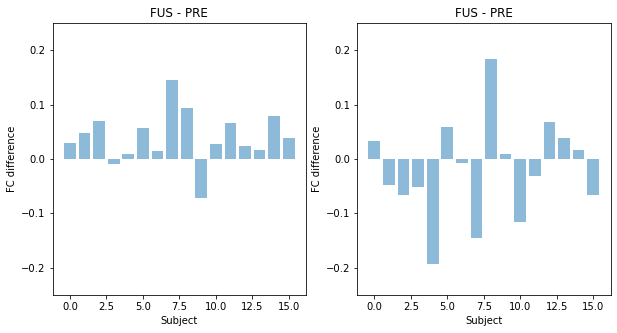

In [12]:
# make a bar plot of t1 vs t2
# Note: the figure in the manuscript shows the same data but in a different format (bar plot with scatter overlay)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(range(16), t1, alpha=0.5, label='active')
ax[0].set_ylim(-0.25, 0.25)
ax[0].set_xlabel('Subject')
ax[0].set_ylabel('FC difference')
ax[0].set_title('FUS - PRE')
ax[1].bar(range(16), t2, alpha=0.5, label='sham')
ax[1].set_ylim(-0.25, 0.25)
ax[1].set_xlabel('Subject')
ax[1].set_ylabel('FC difference')
ax[1].set_title('FUS - PRE')

# Figure 4

Text(0.5, 1.0, 'POST - PRE')

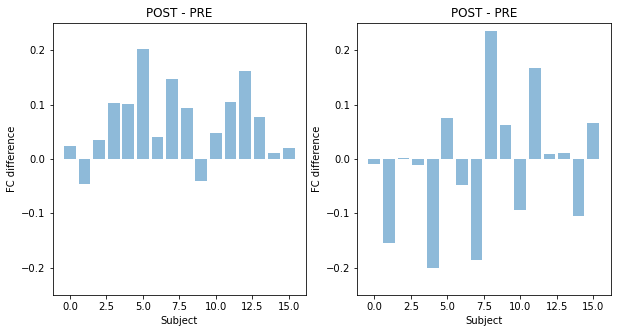

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(range(16), t3, alpha=0.5, label='active')
ax[0].set_ylim(-0.25, 0.25)
ax[0].set_xlabel('Subject')
ax[0].set_ylabel('FC difference')
ax[0].set_title('POST - PRE')
ax[1].bar(range(16), t4, alpha=0.5, label='sham')
ax[1].set_ylim(-0.25, 0.25)
ax[1].set_xlabel('Subject')
ax[1].set_ylabel('FC difference')
ax[1].set_title('POST - PRE')


## Figure 5

In [14]:
## filter df to only rows where either roi1 or roi2 is the subgenual region
df_sg = df[(df.roi1 == subgenual) | (df.roi2 == subgenual)]

## Add a column to the dataframe that contains the connection of the subgenual region to the connected region
df_sg["connection"] = df_sg.apply(lambda x: x['roi1'] if x['roi2'] == subgenual else x['roi2'], axis=1)

# compute the mean and std of the FC values for each condition, time_window, and connection
df_sg_mu = df_sg.groupby(['condition','time_window','connection'])['fc'].mean()
df_sg_std = df_sg.groupby(['condition','time_window','connection'])['fc'].std()

/var/folders/g9/8jw7l6116kdd4pc549qnnz8r0000gn/T/ipykernel_42297/1604280958.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sg["connection"] = df_sg.apply(lambda x: x['roi1'] if x['roi2'] == subgenual else x['roi2'], axis=1)


In [15]:
# convert dfg_mean so that the indices are columns
df_sg_g = df_sg_mu.reset_index()
df_sg_g["mean"] = df_sg_mu.values
df_sg_g["std"] = df_sg_std.values
df_sg_g.drop(columns = 'fc', inplace = True)

In [16]:
df_sg_g.head()

,condition,time_window,connection,mean,std
0,active,fus,Amygdala anterior,0.187152,0.173553
1,active,fus,Amygdala posterior,0.128568,0.151082
2,active,fus,Angular gyrus anterior LH,0.106052,0.165321
3,active,fus,Angular gyrus antero-inferior LH,0.105668,0.187333
4,active,fus,Angular gyrus antero-superior LH,0.114713,0.203230


In [17]:
## create a new dataframe where the time_window is a separate column
df_sg_g2 = df_sg_g.pivot_table(index = ['condition','connection'], columns = 'time_window', values = ['mean','std']).reset_index()

In [18]:
# convert dfg2 to a single level index
df_sg_g2.columns = ['_'.join(col).strip() for col in df_sg_g2.columns.values]
df_sg_g2['condition_'] = df_sg_g2['condition_'].astype(str)
df_sg_g2['connection_'] = df_sg_g2['connection_'].astype(str)

In [19]:
# compute the difference between the mean FC values for the FUS and PRE time windows
df_sg_g2["del_fus"] = df_sg_g2["mean_fus"] - df_sg_g2["mean_pre"]
df_sg_g2["del_post"] = df_sg_g2["mean_post"] - df_sg_g2["mean_pre"]
df_sg_g2["del_pct_change_fus"] = df_sg_g2["del_fus"] / df_sg_g2["std_pre"]
df_sg_g2["del_pct_change_post"] = df_sg_g2["del_post"] / df_sg_g2["std_pre"]

In [20]:
df_sg_g2.groupby('condition_')[['mean_pre','mean_fus','mean_post','del_fus','del_post','del_pct_change_fus','del_pct_change_post']].mean()

,mean_pre,mean_fus,mean_post,del_fus,del_post,del_pct_change_fus,del_pct_change_post
condition_,,,,,,,
active,0.061365,0.100091,0.127845,0.038726,0.066480,0.218605,0.380771
sham,0.121108,0.101353,0.109771,-0.019754,-0.011337,-0.100800,-0.052728


In [21]:
## create a new dataframe where the index is the connection and the columns are: del_fus_active, del_post_active, del_fus_sham, del_post_sham, mean_pre_active, mean_pre_sham
df_sg_g3 = df_sg_g2.pivot_table(index = 'connection_', columns = 'condition_', values = ['del_fus','del_post','mean_pre', 'mean_fus', 'mean_post']).reset_index()
df_sg_g3.columns = ['_'.join(col).strip() for col in df_sg_g3.columns.values]


In [22]:
df_sg_g3

,connection__,del_fus_active,del_fus_sham,del_post_active,del_post_sham,mean_fus_active,mean_fus_sham,mean_post_active,mean_post_sham,mean_pre_active,mean_pre_sham
0,Amygdala anterior,0.002007,0.013971,0.069775,0.034126,0.187152,0.231049,0.254920,0.251204,0.185146,0.217078
1,Amygdala posterior,0.005076,0.032778,-0.027493,0.065765,0.128568,0.118131,0.096000,0.151118,0.123493,0.085353
2,Angular gyrus anterior LH,-0.022773,0.005313,-0.001271,-0.005003,0.106052,0.140325,0.127554,0.130009,0.128824,0.135012
3,Angular gyrus antero-inferior LH,0.030423,-0.028136,0.093997,-0.052981,0.105668,0.159494,0.169242,0.134649,0.075244,0.187630
4,Angular gyrus antero-superior LH,0.078080,-0.115851,0.088599,-0.039411,0.114713,0.024364,0.125232,0.100804,0.036633,0.140215
...,...,...,...,...,...,...,...,...,...,...,...
977,Ventromedial prefrontal cortex anterior,0.002694,0.015498,0.069114,0.022692,0.351058,0.387526,0.417477,0.394720,0.348364,0.372028
978,Ventromedial prefrontal cortex anterior LH,0.059491,-0.052806,0.085674,-0.005362,0.308132,0.309796,0.334315,0.357240,0.248641,0.362602
979,Ventromedial prefrontal cortex antero-inferior,-0.002850,-0.044020,0.021538,-0.055472,0.307256,0.358315,0.331644,0.346863,0.310106,0.402335
980,Ventromedial prefrontal cortex posterior,-0.021542,0.025034,0.011600,0.064626,0.019080,0.075511,0.052222,0.115103,0.040622,0.050478


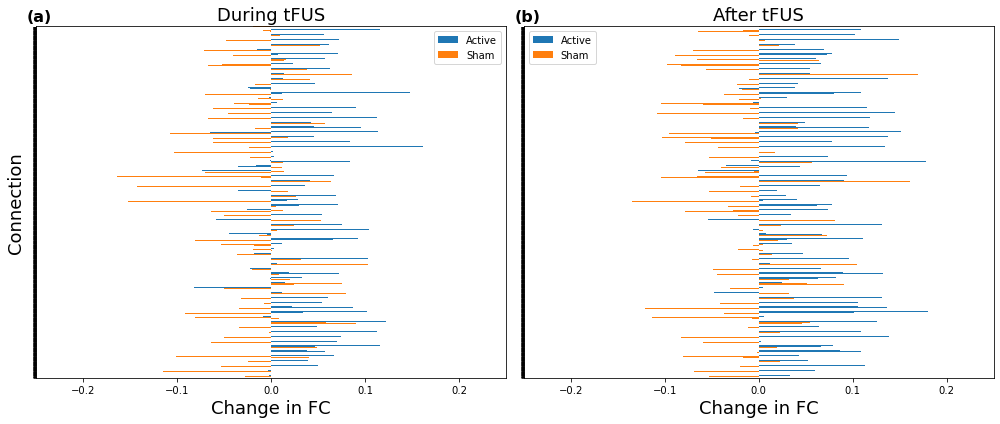

In [23]:
#plt.style.use('dark_background')
fig, ax = plt.subplots(1,2,figsize=(14,6))
fontdict = {'fontsize': 18, 'fontweight': 'normal'}

# create horizontal bar plot with no tick labels on the y-axis
df_sg_g3.plot(x = 'connection__', y = ['del_fus_active','del_fus_sham'], kind = 'barh', ax = ax[0])
ax[0].set_xlabel('Change in FC', fontdict = fontdict)
ax[0].set_yticklabels([])
ax[0].set_ylabel('Connection', fontdict = fontdict)
ax[0].set_title('Change in sgACC FC during FUS', fontdict = fontdict)
ax[0].set_xlim(-0.25,0.25)
ax[0].legend(['Active','Sham'])
df_sg_g3.plot(x = 'connection__', y = ['del_post_active','del_post_sham'], kind = 'barh', ax = ax[1])
ax[1].set_xlabel('Change in FC', fontdict = fontdict)
ax[1].set_yticklabels([])
ax[1].set_ylabel('')
ax[1].set_title('Change in sgACC FC post FUS', fontdict = fontdict)
ax[1].set_xlim(-0.25,0.25)
ax[1].legend(['Active','Sham'])

ax[0].set_title('During tFUS', fontdict=fontdict)
ax[1].set_title('After tFUS', fontdict=fontdict)

# add sublabels (a) and (b) to the plots
ax[0].text(-0.02, 1.05, '(a)', transform=ax[0].transAxes, fontsize=16, fontweight='bold', va='top')
ax[1].text(-0.02, 1.05, '(b)', transform=ax[1].transAxes, fontsize=16, fontweight='bold', va='top')


fig.tight_layout()
fig.savefig('../figures/sgACC_fc_change.png', dpi=300)

In [24]:
dfg3['del_fus_active'].ge(0).mean(), dfg3['del_fus_sham'].ge(0).mean(), dfg3['del_post_active'].ge(0).mean(), dfg3['del_post_sham'].ge(0).mean()


NameError: name 'dfg3' is not defined

## Visualize FC changes as a network graph

In [ ]:
# Load DiFuMo atlas
#roi_coordinates = plotting.find_probabilistic_atlas_cut_coords(difumo.maps)  # Anatomical coordinates of ROIs

In [ ]:
#roi_labels = difumo.labels
#roi_labels = [x[1] for x in roi_labels]

In [ ]:
# get the coordinates of each ROI in the difumo atlas
#roi_to_coords = {label: coord for label, coord in zip(roi_labels, roi_coordinates)}

In [ ]:
# Example: Top connections DataFrame (replace this with your actual data)
#data = [
#    ["sgACC", "Paracingulate sulcus middle LH", 0.173897],
#    ["sgACC", "Middle temporal gyrus middle RH", 0.172191],
#    ["sgACC", "Lingual gyrus anterior RH", 0.168216],
#    ["sgACC", "Anterior orbital gyrus RH", 0.164764],
#    ["sgACC", "Parieto-occipital sulcus mid-anterior LH", 0.162196],
#]
#columns = ["seed", "target", "del_fus"]
#df = pd.DataFrame(data, columns=columns)


In [ ]:
# Get coordinates for seed and target ROIs
#df["seed_coords"] = df["seed"].apply(lambda x: roi_to_coords.get(x, (np.nan, np.nan, np.nan)))
#df["target_coords"] = df["target"].apply(lambda x: roi_to_coords.get(x, (np.nan, np.nan, np.nan)))

# Filter out invalid coordinates
#df = df.dropna(subset=["seed_coords", "target_coords"])

# Extract connectivity data for plotting
#connectivity_matrix = np.zeros((len(df), len(df)))
#for idx, row in df.iterrows():
#    seed_idx = idx
#    target_idx = idx
#    connectivity_matrix[seed_idx, target_idx] = row["del_fus"]

# Extract coordinates
#node_coords = np.array([row["target_coords"] for _, row in df.iterrows()])

# Plot the connectome
#plotting.plot_connectome(
#    adjacency_matrix=connectivity_matrix,
#    node_coords=node_coords,
#)
#view.open_in_browser()  # Opens the interactive visualization in your browser

In [ ]:
#connectivity_matrix

In [ ]:

# Keywords for DMN and affective networks
#dmn_keywords = ["medial prefrontal", "posterior cingulate", "parahippocampal", "hippocampus"]
#affective_keywords = ["amygdala", "insula", "orbitofrontal", "ventral striatum", "thalamus"]

# Filter for relevant regions
#dmn_regions = df_labels[df_labels["Label"].str.contains("|".join(dmn_keywords), case=False, na=False)]
#affective_regions = df_labels[df_labels["Label"].str.contains("|".join(affective_keywords), case=False, na=False)]

# Combine results
#relevant_regions = pd.concat([dmn_regions, affective_regions]).drop_duplicates()

# Save or print the relevant regions
#print("Regions in DMN and Affective Networks:")
#print(relevant_regions)

# Save to CSV (optional)
#relevant_regions.to_csv("dmn_affective_regions.csv", index=False)